In [1]:
import warnings; warnings.filterwarnings("ignore", message="Initializing zero-element tensors is a no-op")
import pandas as pd
import torch

from eval_utils import get_pairs, eval_epochs

import sys
sys.path.insert(0, '../')

from utils import aug_transform, simple_transform
from models.mini_inception_resnet_v1 import MiniInceptionResNetV1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMAGES_PATH = '../data/'
EPOCHS_PATH = '../checkpoints/'

In [2]:
test_df = pd.read_csv('../data/mnist_test.csv')
print(f'Test data shape: {test_df.shape}')

pairs = get_pairs(test_df, 1000)
print(f'Pairs shape: {pairs.shape}')

Test data shape: (10000, 785)
Pairs shape: (1000, 3)


In [3]:
pairs.head(1)

,img1,img2,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


Calculating distances: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


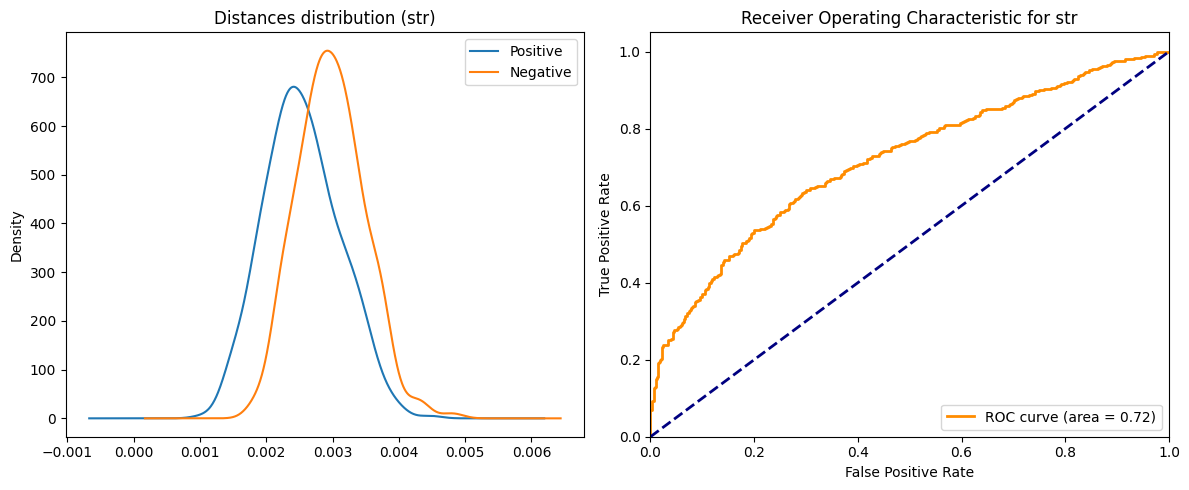

Target FAR: 1e-02 | Threshold: 0.0019
[epoch_1.pt] Accuracy: 0.5690
[epoch_1.pt] VAL: 0.1480 | FAR: 0.0100

[epoch_1.pt] Positive mean: 0.0025 ± 0.0006
[epoch_1.pt] Negative mean: 0.0030 ± 0.0005


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 76.10it/s]


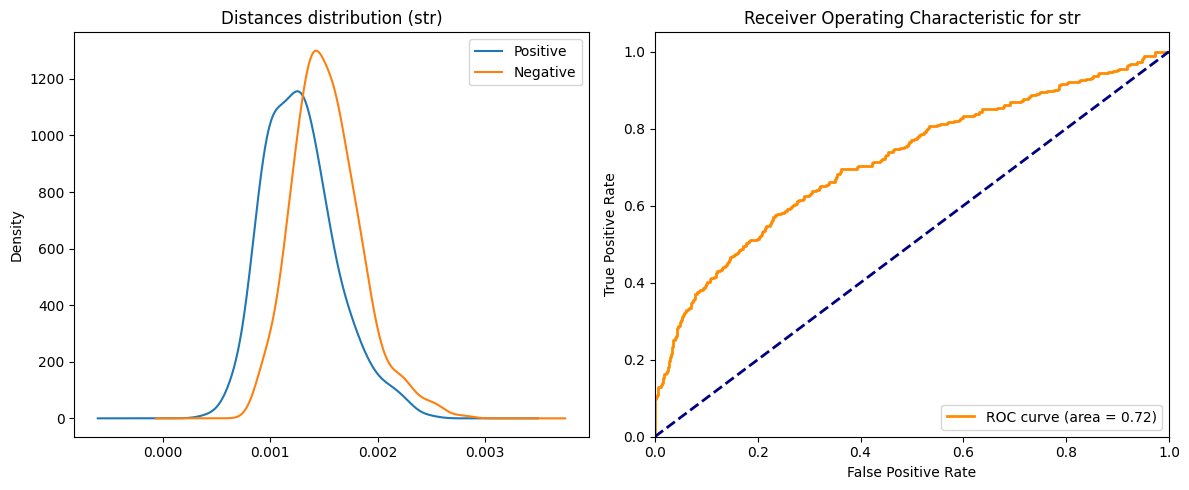

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_2.pt] Accuracy: 0.5600
[epoch_2.pt] VAL: 0.1280 | FAR: 0.0080

[epoch_2.pt] Positive mean: 0.0013 ± 0.0003
[epoch_2.pt] Negative mean: 0.0015 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 111.54it/s]


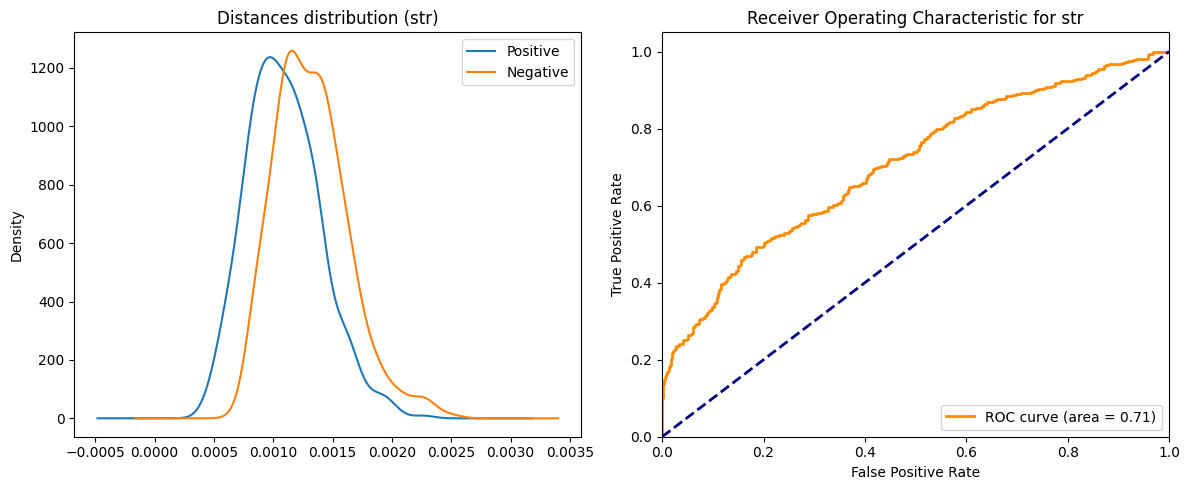

Target FAR: 1e-02 | Threshold: 0.0008
[epoch_3.pt] Accuracy: 0.5780
[epoch_3.pt] VAL: 0.1660 | FAR: 0.0100

[epoch_3.pt] Positive mean: 0.0011 ± 0.0003
[epoch_3.pt] Negative mean: 0.0013 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 111.52it/s]


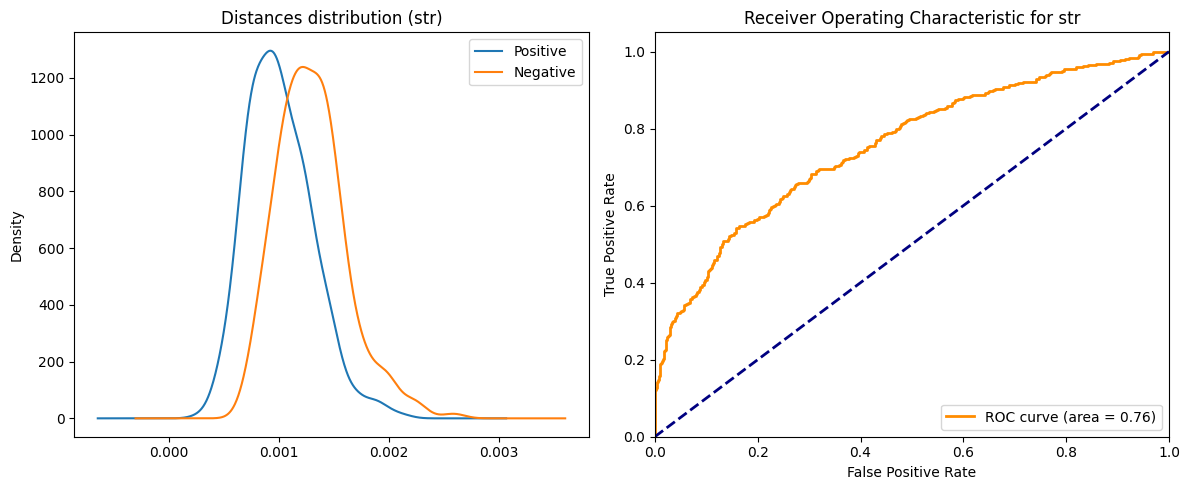

Target FAR: 1e-02 | Threshold: 0.0007
[epoch_4.pt] Accuracy: 0.5890
[epoch_4.pt] VAL: 0.1880 | FAR: 0.0100

[epoch_4.pt] Positive mean: 0.0010 ± 0.0003
[epoch_4.pt] Negative mean: 0.0013 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 110.65it/s]


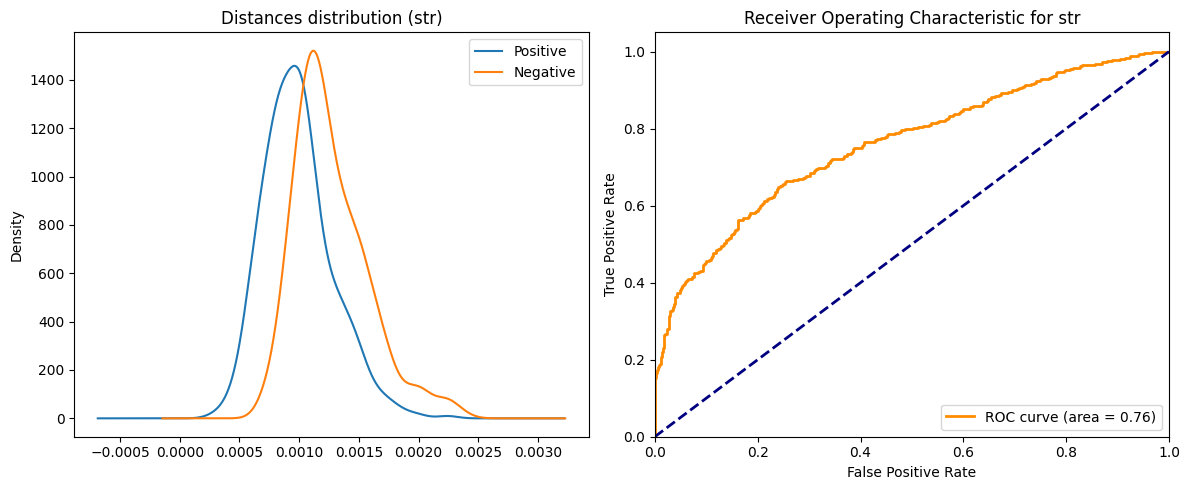

Target FAR: 1e-02 | Threshold: 0.0007
[epoch_5.pt] Accuracy: 0.5890
[epoch_5.pt] VAL: 0.1880 | FAR: 0.0100

[epoch_5.pt] Positive mean: 0.0010 ± 0.0003
[epoch_5.pt] Negative mean: 0.0013 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 98.84it/s] 


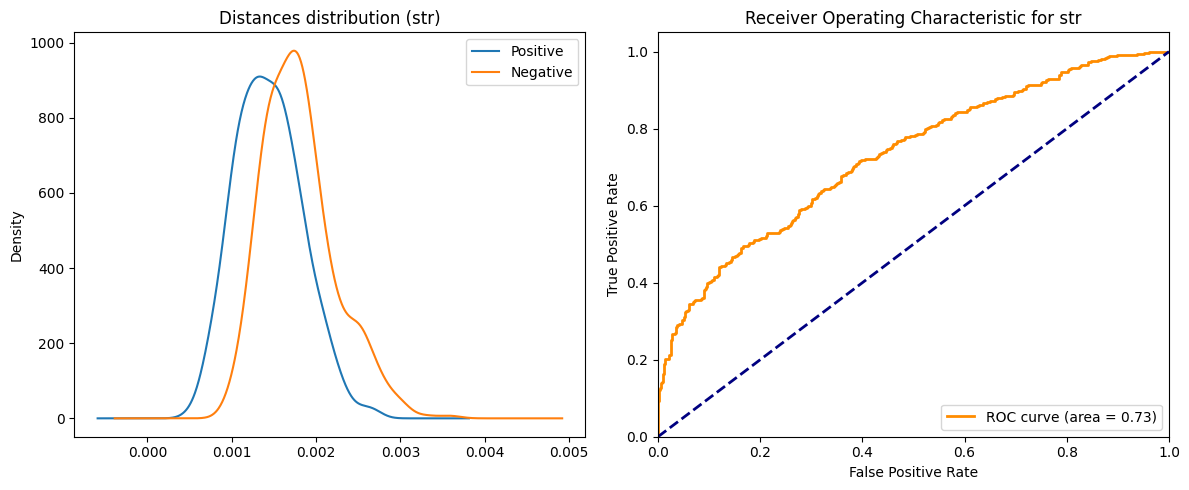

Target FAR: 1e-02 | Threshold: 0.0010
[epoch_6.pt] Accuracy: 0.5760
[epoch_6.pt] VAL: 0.1620 | FAR: 0.0100

[epoch_6.pt] Positive mean: 0.0014 ± 0.0004
[epoch_6.pt] Negative mean: 0.0018 ± 0.0004


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 105.79it/s]


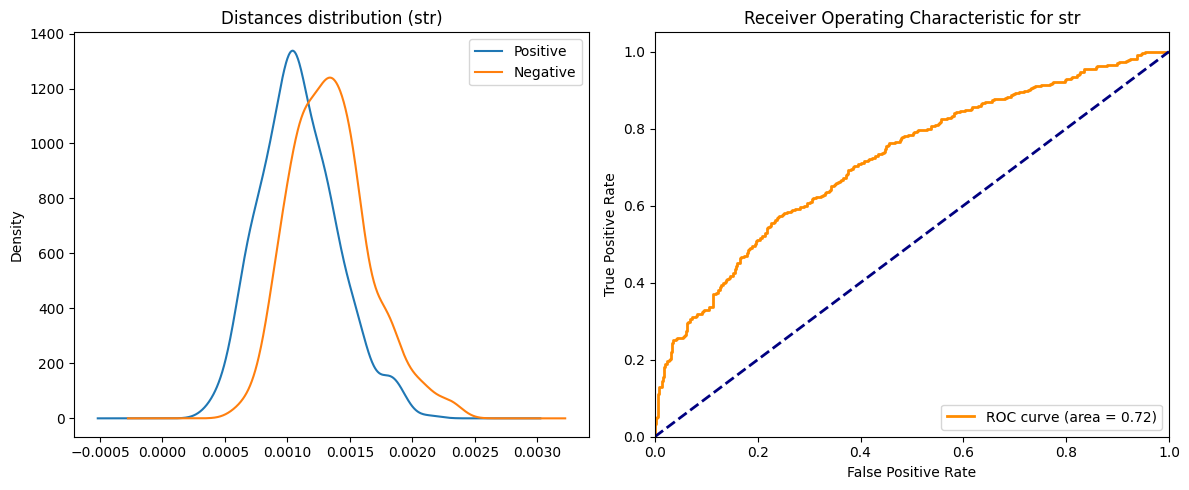

Target FAR: 1e-02 | Threshold: 0.0007
[epoch_7.pt] Accuracy: 0.5590
[epoch_7.pt] VAL: 0.1260 | FAR: 0.0080

[epoch_7.pt] Positive mean: 0.0011 ± 0.0003
[epoch_7.pt] Negative mean: 0.0013 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 106.56it/s]


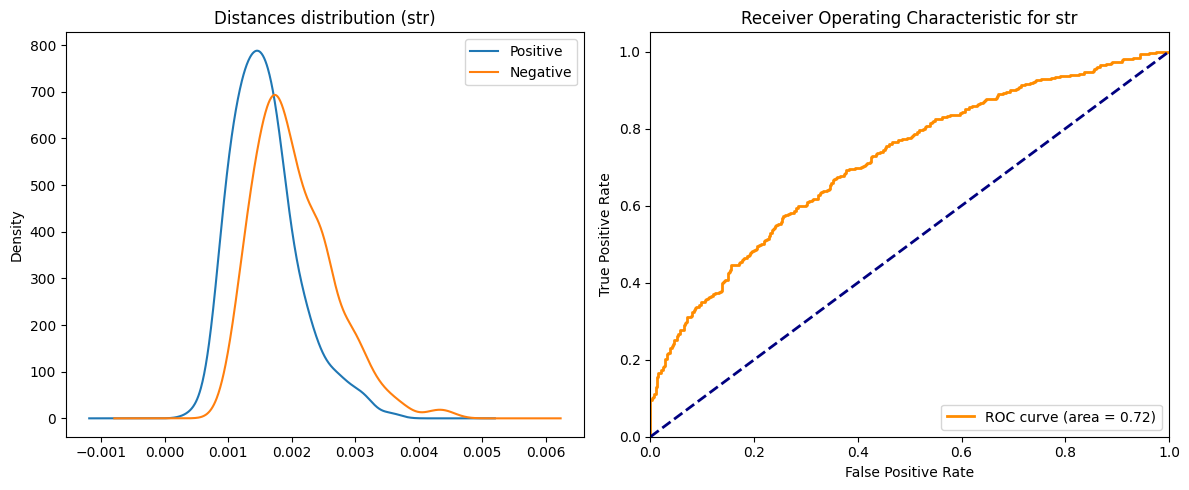

Target FAR: 1e-02 | Threshold: 0.0010
[epoch_8.pt] Accuracy: 0.5580
[epoch_8.pt] VAL: 0.1260 | FAR: 0.0100

[epoch_8.pt] Positive mean: 0.0016 ± 0.0005
[epoch_8.pt] Negative mean: 0.0020 ± 0.0006


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 94.98it/s] 


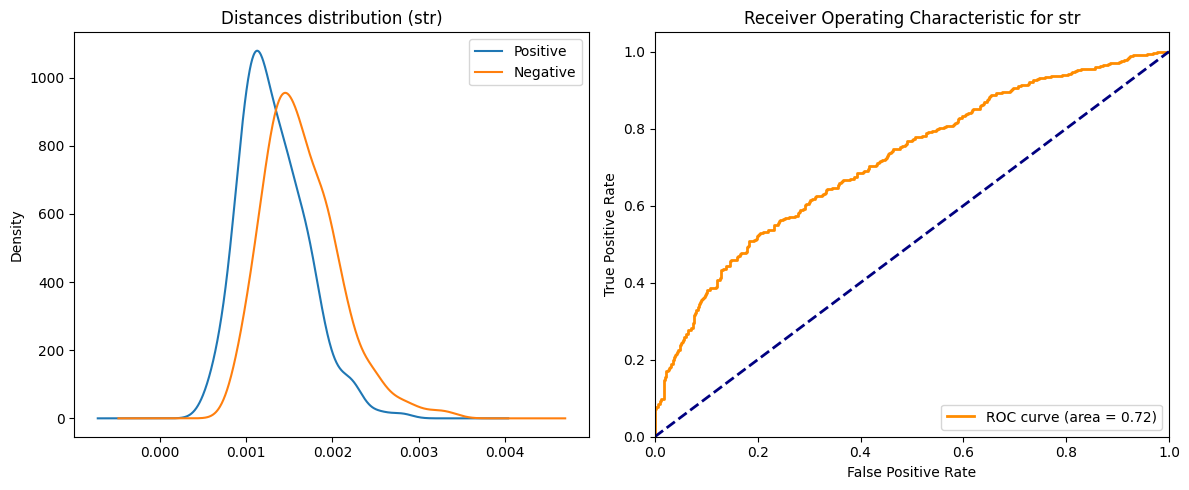

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_9.pt] Accuracy: 0.5400
[epoch_9.pt] VAL: 0.0900 | FAR: 0.0100

[epoch_9.pt] Positive mean: 0.0013 ± 0.0004
[epoch_9.pt] Negative mean: 0.0016 ± 0.0004


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 46.05it/s]


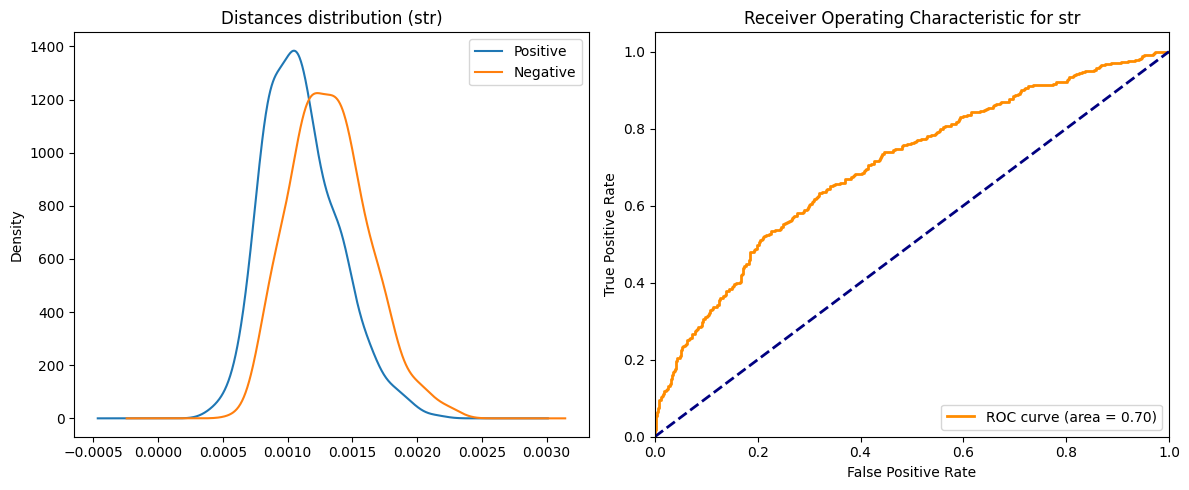

Target FAR: 1e-02 | Threshold: 0.0008
[epoch_10.pt] Accuracy: 0.5430
[epoch_10.pt] VAL: 0.0940 | FAR: 0.0080

[epoch_10.pt] Positive mean: 0.0011 ± 0.0003
[epoch_10.pt] Negative mean: 0.0013 ± 0.0003


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 86.34it/s]


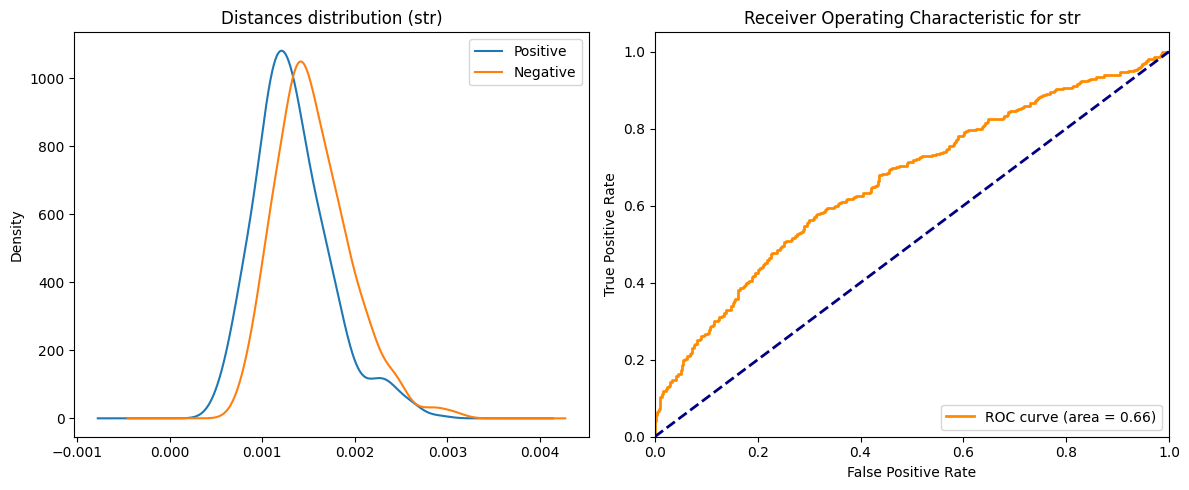

Target FAR: 1e-02 | Threshold: 0.0008
[epoch_11.pt] Accuracy: 0.5460
[epoch_11.pt] VAL: 0.1020 | FAR: 0.0100

[epoch_11.pt] Positive mean: 0.0013 ± 0.0004
[epoch_11.pt] Negative mean: 0.0016 ± 0.0004


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 94.15it/s]


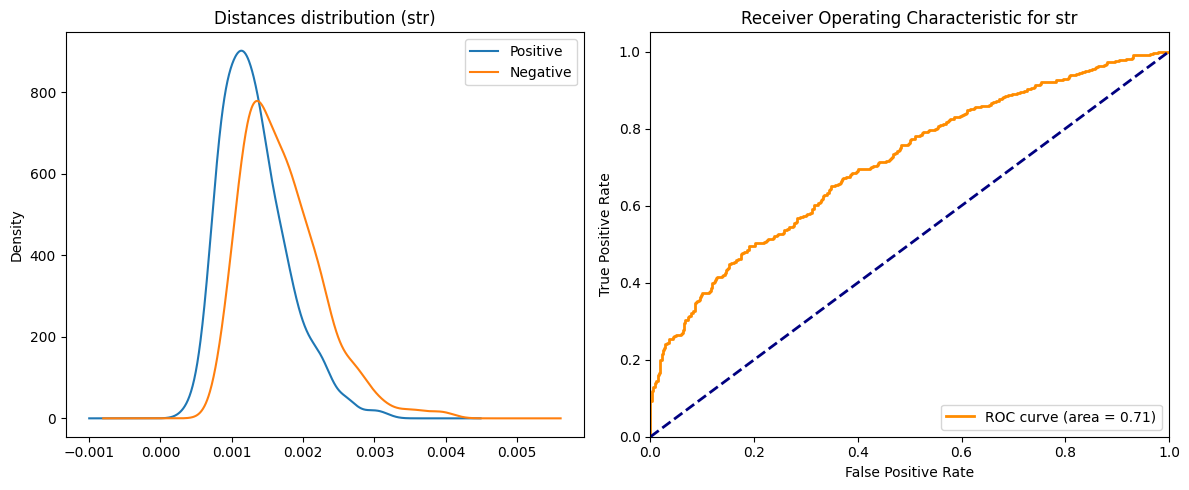

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_12.pt] Accuracy: 0.5660
[epoch_12.pt] VAL: 0.1420 | FAR: 0.0100

[epoch_12.pt] Positive mean: 0.0013 ± 0.0005
[epoch_12.pt] Negative mean: 0.0017 ± 0.0006


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 79.16it/s]


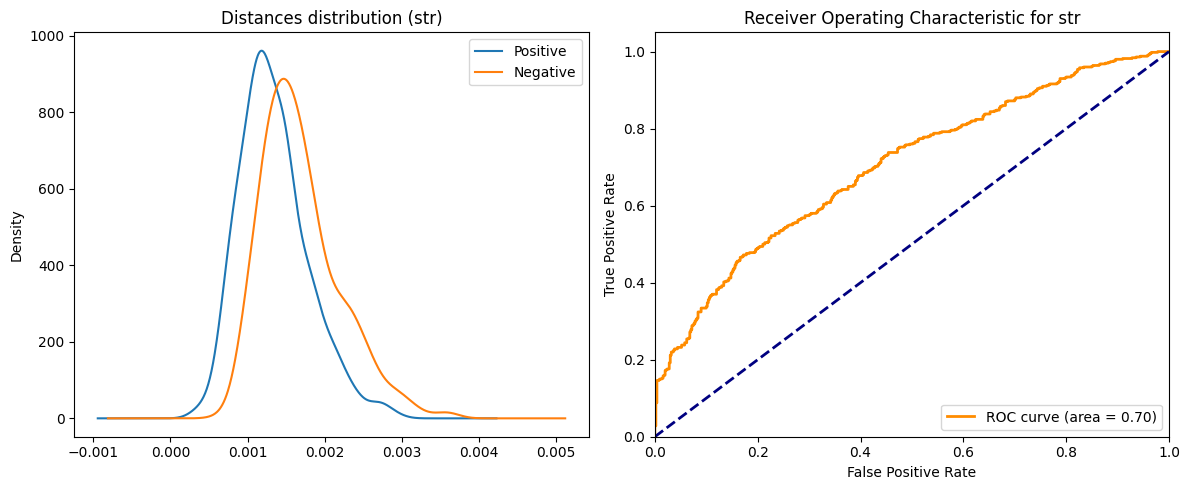

Target FAR: 1e-02 | Threshold: 0.0009
[epoch_13.pt] Accuracy: 0.5690
[epoch_13.pt] VAL: 0.1480 | FAR: 0.0100

[epoch_13.pt] Positive mean: 0.0013 ± 0.0004
[epoch_13.pt] Negative mean: 0.0017 ± 0.0005


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 85.13it/s]


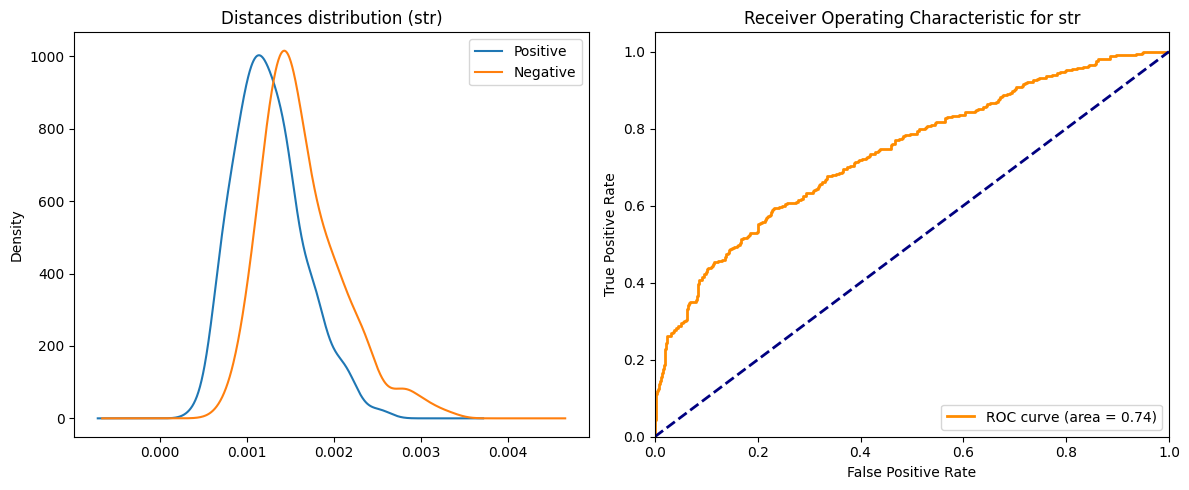

Target FAR: 1e-02 | Threshold: 0.0008
[epoch_14.pt] Accuracy: 0.5660
[epoch_14.pt] VAL: 0.1420 | FAR: 0.0100

[epoch_14.pt] Positive mean: 0.0013 ± 0.0004
[epoch_14.pt] Negative mean: 0.0016 ± 0.0005


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 83.28it/s]


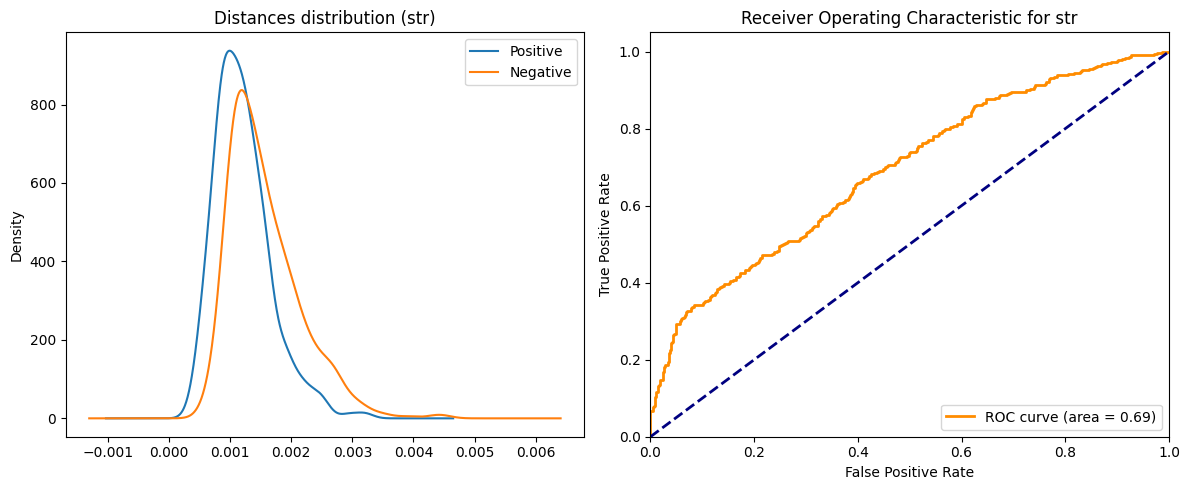

Target FAR: 1e-02 | Threshold: 0.0007
[epoch_15.pt] Accuracy: 0.5520
[epoch_15.pt] VAL: 0.1140 | FAR: 0.0100

[epoch_15.pt] Positive mean: 0.0012 ± 0.0005
[epoch_15.pt] Negative mean: 0.0016 ± 0.0006


Calculating distances: 100%|██████████| 32/32 [00:00<00:00, 84.84it/s] 


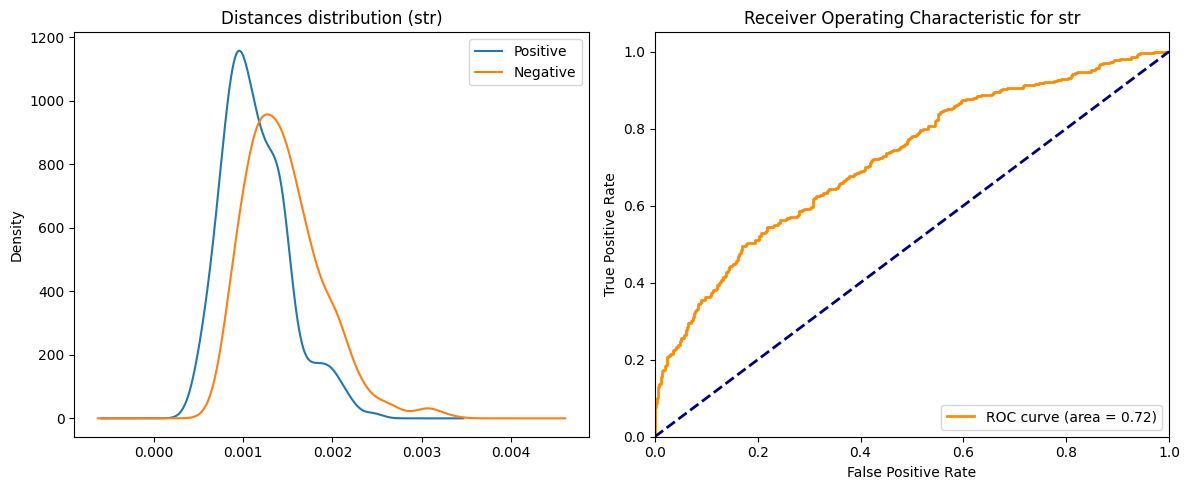

Target FAR: 1e-02 | Threshold: 0.0008
[epoch_16.pt] Accuracy: 0.5630
[epoch_16.pt] VAL: 0.1360 | FAR: 0.0100

[epoch_16.pt] Positive mean: 0.0011 ± 0.0004
[epoch_16.pt] Negative mean: 0.0015 ± 0.0004


In [4]:
eval_epochs(epochs_path=EPOCHS_PATH, 
            pairs=pairs,
            model_class=MiniInceptionResNetV1, 
            batch_size=32, 
            transform=simple_transform, 
            device=device,
            target_far=1e-2)